In [74]:
import sklearn
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np 

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

### Read Data

In [7]:
df = pd.read_csv("dataset-of-00s.csv")
df = df.drop(['uri', 'track', 'artist'], axis = 1)

### EDA

In [21]:
df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.1590,0.532,133.061,196707,4,30.88059,13,1
1,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.1480,0.688,92.988,242587,4,41.51106,10,1
2,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.1740,0.300,86.964,338893,4,65.32887,13,0
3,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.1920,0.333,148.440,255667,4,58.59528,9,0
4,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.1250,0.631,112.098,193760,4,22.62384,10,1
5,0.726,0.837,11,-7.223,0,0.0965,0.373000,0.26800,0.1360,0.969,135.347,192720,4,28.29051,10,0
6,0.365,0.922,1,-2.644,1,0.0710,0.002850,0.00000,0.3210,0.290,77.250,89427,4,45.77202,4,0
7,0.726,0.631,11,-8.136,0,0.0334,0.220000,0.00000,0.1930,0.746,124.711,239240,4,35.59732,10,1
8,0.481,0.786,10,-5.654,1,0.0288,0.053800,0.00000,0.0759,0.389,153.105,253640,4,19.65701,11,1
9,0.647,0.324,7,-9.679,1,0.0377,0.354000,0.00000,0.1150,0.344,124.213,314286,3,32.66343,16,0


In [8]:
df['target'].value_counts()

1    2936
0    2936
Name: target, dtype: int64

In [9]:
df.isna().any()

danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
duration_ms         False
time_signature      False
chorus_hit          False
sections            False
target              False
dtype: bool

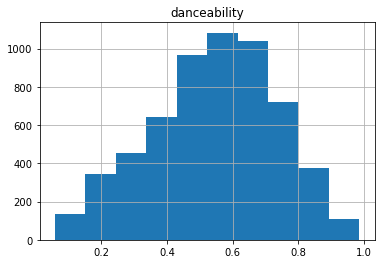

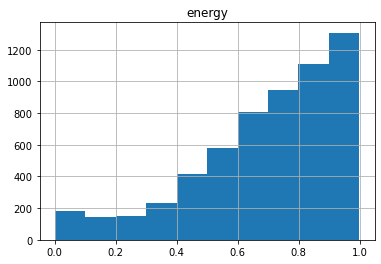

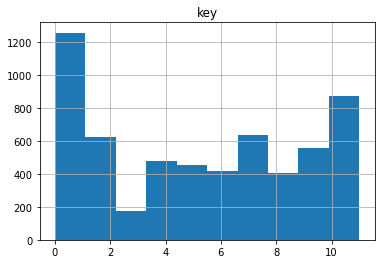

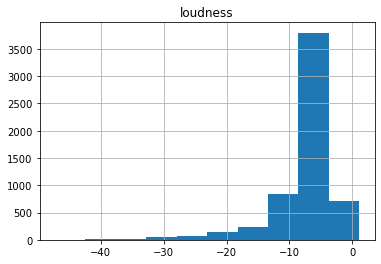

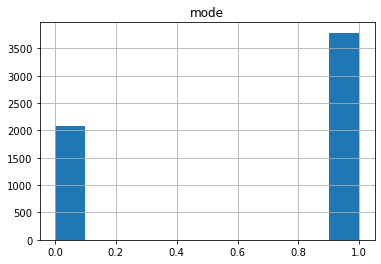

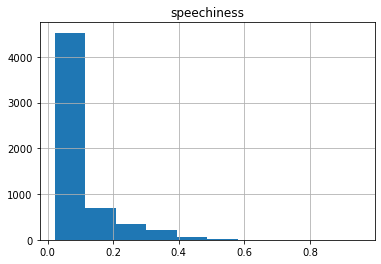

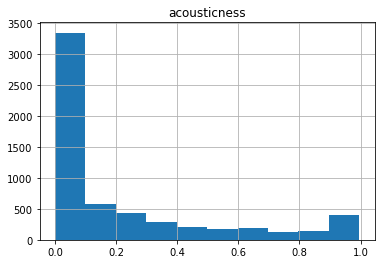

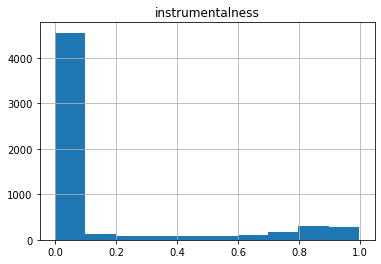

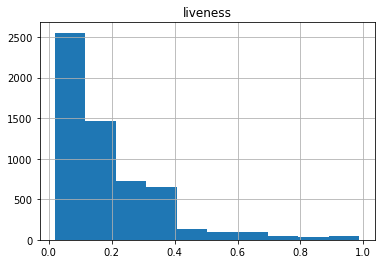

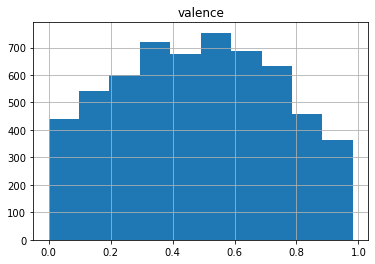

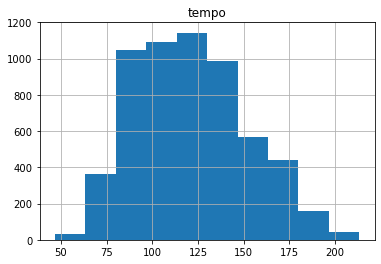

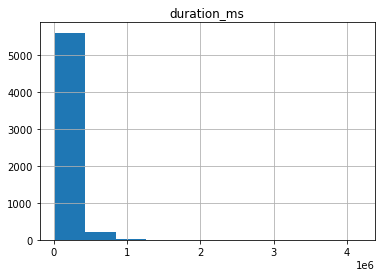

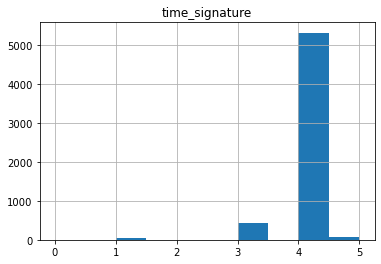

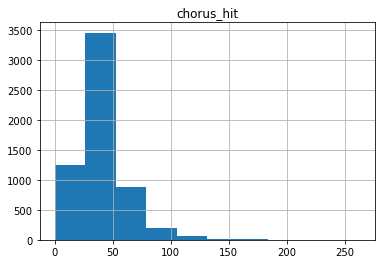

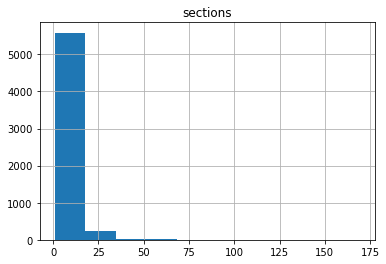

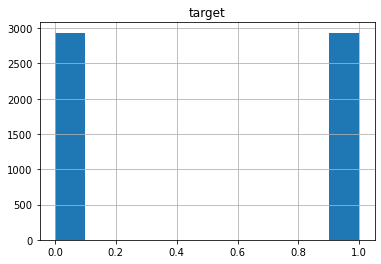

In [18]:
for variable in df.columns:
    df[variable].hist()
    plt.title(variable)
    plt.show()

<AxesSubplot:>

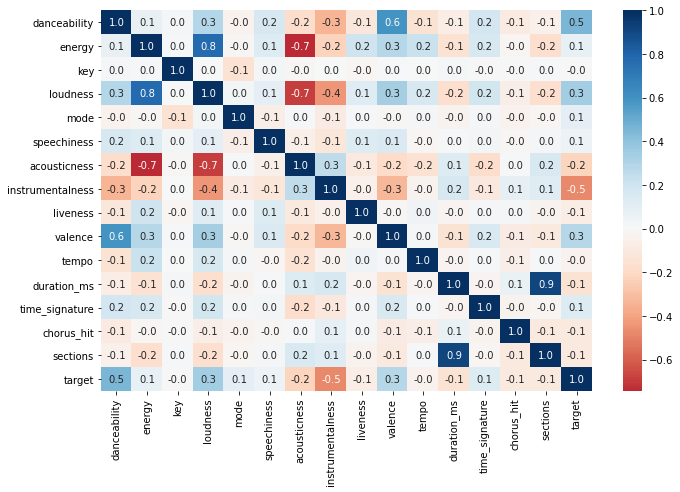

In [10]:
corr = df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(corr, annot = True, fmt = '.1f', cmap = 'RdBu', center = 0, ax = ax)

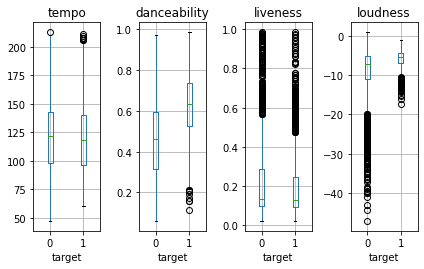

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols = 4)
df.boxplot(column = 'tempo', by = 'target', ax = axes[0])
df.boxplot(column = 'danceability', by = 'target', ax = axes[1])
df.boxplot(column = 'liveness', by = 'target', ax = axes[2])
df.boxplot(column = 'loudness', by = 'target', ax = axes[3]) 

for ax in axes:
    ax.set_xlabel('target')
    
plt.suptitle('')
plt.tight_layout()

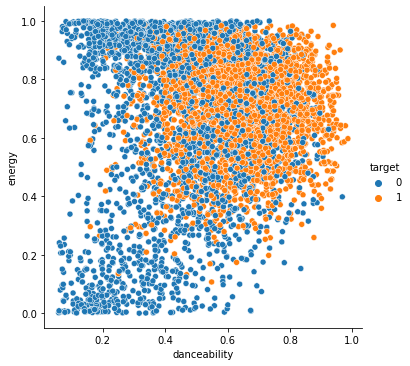

In [17]:
sns.relplot(x = 'danceability', y = 'energy', hue = 'target', data = df)

<Figure size 792x504 with 0 Axes>

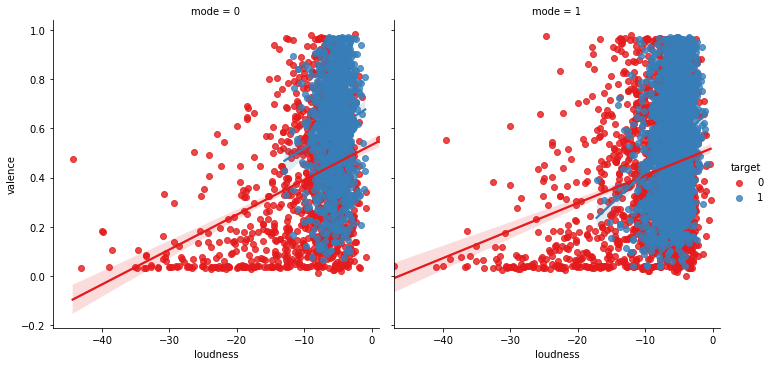

In [22]:
plt.figure(figsize=(11,7))
sns.lmplot(x = 'loudness', y = 'valence', col = 'mode', hue = 'target', palette='Set1', data = df )

### Observations: 

1) Dataset is balanced. In other words, our target variable (hit or flop) has an equal amount of observations.

2) Many of our features are equally distributed. 

3) There seems to be a high correlation between loudeness, danceability, energy and our target variable.

#### Now it's time to split our data and train our model. For this dataset, I will implement a RandomForest classifier model.

### Split Data

In [66]:
X = df.drop('target', axis = 1)
y = df['target']

In [67]:
X_train, X_valid, y_train, y_valid  = train_test_split(X, y, test_size = 0.3, random_state = 123)

### Model Building

In [68]:
parameters = {"max_depth":range(2, 8), "min_samples_leaf": range(5, 55, 5), "min_samples_split": range(10, 110, 5),
              "max_samples":[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], "max_features": [2, 3, 4, 5, 6],
              "n_estimators": [100, 150, 200, 250, 300, 350, 400]}

start = time.time() 

clf_cv = RandomizedSearchCV(RandomForestClassifier(), parameters, n_jobs=4, scoring = "roc_auc", n_iter = 200,
                        random_state = 0) 

clf_cv.fit(X_train, y_train) 

end = time.time() 

print("Total time in seconds ==> ", end - start)

Total time in seconds ==>  106.03920316696167


In [69]:
clf_cv.best_params_

{'n_estimators': 400,
 'min_samples_split': 20,
 'min_samples_leaf': 5,
 'max_samples': 0.25,
 'max_features': 3,
 'max_depth': 7}

In [70]:
imp = pd.DataFrame()

imp["var"] = X_train.columns

imp["imp"] = clf_cv.best_estimator_.feature_importances_ 

imp = imp.sort_values("imp", ascending = False).reset_index(drop = True) 

imp

,var,imp
0,instrumentalness,0.314805
1,danceability,0.147802
2,loudness,0.112222
3,acousticness,0.102353
4,duration_ms,0.097013
5,energy,0.072320
6,valence,0.050749
7,speechiness,0.032817
8,sections,0.020241
9,tempo,0.014223


In [71]:
train_pred = clf_cv.predict(X_train)
val_pred = clf_cv.predict(X_valid)

In [72]:
y_train_prob = clf_cv.predict_proba(X_train)
y_val_prob = clf_cv.predict_proba(X_valid)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
print("Training AUC: ", metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_val_prob[:,1], pos_label = 1)
print("Validation AUC: ", metrics.auc(fpr, tpr))

Training AUC:  0.9293716206743684
Validation AUC:  0.916764620968407


<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

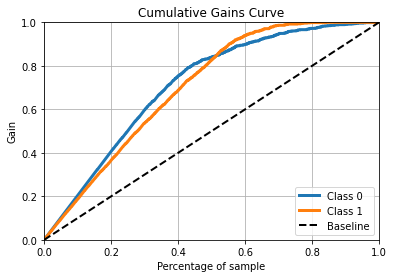

In [75]:
skplt.metrics.plot_cumulative_gain(y_valid,y_val_prob)

Confusion matrix, without normalization
[[692 172]
 [ 89 809]]
Normalized confusion matrix
[[0.80092593 0.19907407]
 [0.09910913 0.90089087]]


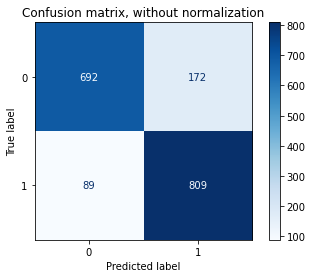

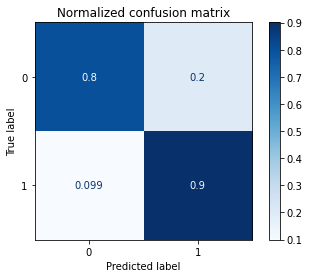

In [37]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_cv, X_valid, y_valid,
                                 
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)